# Hair Fall Prediction

## Step 1: Data Collection and Preprocessing

### First step is to obtain the data. 
The data is stored in a variable titled 'data' that is a pandas data frame. <br>
Next, taking a look at the data frame to ensure it was read properly from the CSV file. This also shows there are a total of 13 columns, with variable 'Hair Loss' being the target variable. 

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [7]:
data = pd.read_csv("Predict Hair Fall.csv")

data.head()

,Id,Genetics,Hormonal Changes,Medical Conditions,Medications & Treatments,Nutritional Deficiencies,Stress,Age,Poor Hair Care Habits,Environmental Factors,Smoking,Weight Loss,Hair Loss
0,133992,Yes,No,No Data,No Data,Magnesium deficiency,Moderate,19,Yes,Yes,No,No,0
1,148393,No,No,Eczema,Antibiotics,Magnesium deficiency,High,43,Yes,Yes,No,No,0
2,155074,No,No,Dermatosis,Antifungal Cream,Protein deficiency,Moderate,26,Yes,Yes,No,Yes,0
3,118261,Yes,Yes,Ringworm,Antibiotics,Biotin Deficiency,Moderate,46,Yes,Yes,No,No,0
4,111915,No,No,Psoriasis,Accutane,Iron deficiency,Moderate,30,No,Yes,Yes,No,1


### Next step is addressing missing and duplicated values.
Moving on to inspecting the data to make sure there are no missing or duplicate values. <br>
There are rows in the categorical column that have no data available. To prevent skewed results in the model it would be better to remove them. 

Additionally, for the categorical variables it is important to check that the data is not imbalanced - the different categories of each variable are represented about the same. In other words, there is not a big different between the majority and minority classes of each variable. 

The numerical variable, Age, is checked for normal distribution as that is ideal to prevent skewed results. 

In [8]:
#Checking if there are duplicated or na rows 
data.isna().sum()
data.duplicated().sum()
data.columns = data.columns.str.strip()

# Removing the 'No Data' rows from the dataset 
cleaned_data = data[data['Medical Conditions'] != 'No Data']
cleaned_data = cleaned_data[data['Nutritional Deficiencies'] != 'No Data']

#Overview of the cleaned data 
cleaned_data = cleaned_data.reset_index(drop=True)
cleaned_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Id                        809 non-null    int64 
 1   Genetics                  809 non-null    object
 2   Hormonal Changes          809 non-null    object
 3   Medical Conditions        809 non-null    object
 4   Medications & Treatments  809 non-null    object
 5   Nutritional Deficiencies  809 non-null    object
 6   Stress                    809 non-null    object
 7   Age                       809 non-null    int64 
 8   Poor Hair Care Habits     809 non-null    object
 9   Environmental Factors     809 non-null    object
 10  Smoking                   809 non-null    object
 11  Weight Loss               809 non-null    object
 12  Hair Loss                 809 non-null    int64 
dtypes: int64(3), object(10)
memory usage: 82.3+ KB


/var/folders/9_/539p0xws1m90qpz24x7p8smh0000gn/T/ipykernel_927/2114212977.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleaned_data = cleaned_data[data['Nutritional Deficiencies'] != 'No Data']


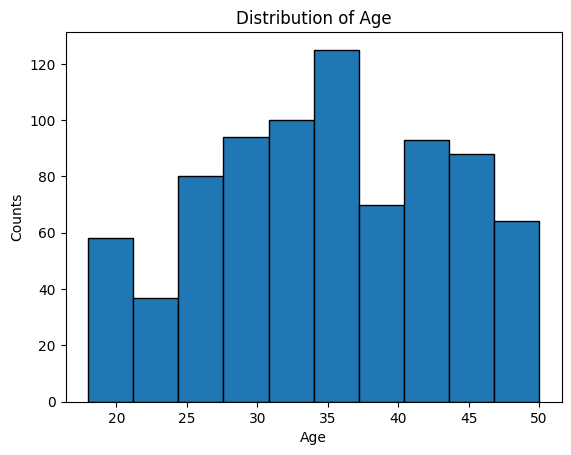

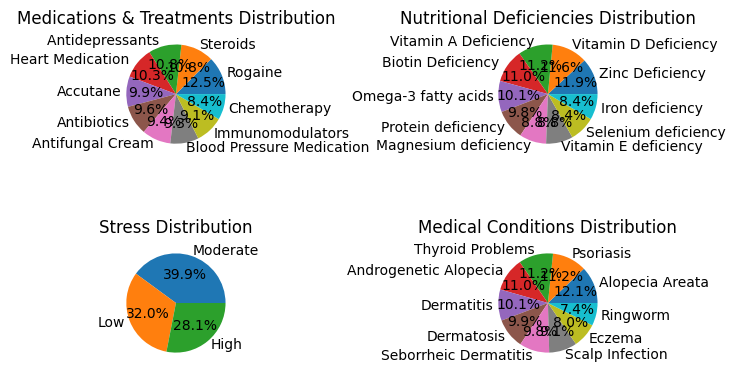

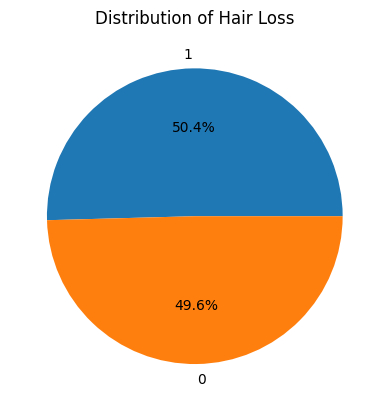

,Environmental Factors,Genetics,Hormonal Changes,Poor Hair Care Habits,Smoking
No,0.490729,0.491965,0.487021,0.508035,0.478368
Yes,0.509271,0.508035,0.512979,0.491965,0.521632


In [43]:
### Checking for data distribution 
plt.hist(cleaned_data['Age'], bins = 10, edgecolor = 'black')
plt.title("Distribution of Age")
plt.xlabel('Age')
plt.ylabel('Counts')
plt.show() 


data_distribution = pd.DataFrame({
    'Environmental Factors': cleaned_data['Environmental Factors'].value_counts(normalize=True),
    'Genetics': cleaned_data['Genetics'].value_counts(normalize=True),
    'Hormonal Changes': cleaned_data['Hormonal Changes'].value_counts(normalize=True),
    'Poor Hair Care Habits': cleaned_data['Poor Hair Care Habits'].value_counts(normalize=True),
    'Smoking': cleaned_data['Smoking'].value_counts(normalize=True)
    #'Hair Loss': cleaned_data['Hair Loss'].value_counts(normalize=True)
})

fig, ax = plt.subplots(2,2)

ax[0, 0].pie(cleaned_data['Medications & Treatments'].value_counts(), labels=cleaned_data['Medications & Treatments'].value_counts().index, autopct='%1.1f%%')
ax[0, 0].set_title('Medications & Treatments Distribution')

ax[1, 0].pie(cleaned_data['Stress'].value_counts(), labels=cleaned_data['Stress'].value_counts().index, autopct='%1.1f%%')
ax[1, 0].set_title('Stress Distribution')

ax[1, 1].pie(cleaned_data['Medical Conditions'].value_counts(), labels=cleaned_data['Medical Conditions'].value_counts().index, autopct='%1.1f%%')
ax[1, 1].set_title('Medical Conditions Distribution')

ax[0, 1].pie(cleaned_data['Nutritional Deficiencies'].value_counts(), labels=cleaned_data['Nutritional Deficiencies'].value_counts().index, autopct='%1.1f%%')
ax[0, 1].set_title('Nutritional Deficiencies Distribution')

plt.subplots_adjust(hspace=0.3, wspace=2)
plt.show()

plt.pie(cleaned_data['Hair Loss'].value_counts(), labels=cleaned_data['Hair Loss'].value_counts().index, autopct='%1.1f%%')
plt.title("Distribution of Hair Loss")
plt.show()

display(data_distribution)


### Lastly, encoding categorical variables in the data.
Most of the data is categorical in this case so there is no need for normalization of values. Instead, it is important to change these categorical variables into numerical values via encoding. <br>

**One-Hot Encoding:** All variables except 'Stress' will use one-hot encoding because there is no inherit hierarchy present in those variables. <br>
**Label-Encoding:** The variable 'Stress' has an implicit hierarchy involved when determing how stressed the individual is, thus, label-encoding will work best for this variable. 

In [46]:
###Starting with label encoding 
ohe = OneHotEncoder(sparse_output=False).set_output(transform='pandas') 

ohetransform_binary = ohe.fit_transform(cleaned_data[['Genetics', 'Hormonal Changes', 'Poor Hair Care Habits', 'Environmental Factors', 'Smoking', 'Weight Loss']])
#ohetransform_binary

ohetransform_conditions = ohe.fit_transform(cleaned_data[['Medical Conditions']])
#ohetransform_conditions.columns

ohetransform_meds = ohe.fit_transform(cleaned_data[['Medications & Treatments']])
#ohetransform_meds.columns

ohetransform_vitamins = ohe.fit_transform(cleaned_data[['Nutritional Deficiencies']])
#ohetransform_vitamins.columns

data_transformed = cleaned_data.drop(['Genetics', 'Hormonal Changes', 'Poor Hair Care Habits', 'Environmental Factors', 'Smoking', 'Weight Loss', 'Medical Conditions', 
                                    'Medications & Treatments', 'Nutritional Deficiencies'], axis=1)

### Moving on to Label Encoding 
le = LabelEncoder()
le_transform = le.fit_transform(cleaned_data[['Stress']])
data_transformed['Stress'] = pd.DataFrame(le_transform, columns =['Stress'])

### Now Combining all the Columns 
data_transformed = pd.concat([data_transformed, ohetransform_binary, ohetransform_conditions, ohetransform_meds, ohetransform_vitamins], axis = 1) #, ohetransform_conditions, ohetransform_meds, ohetransform_vitamins
data_transformed.head()


/Users/tanishasahu/Downloads/School/DS Final Proj/env/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Id,Stress,Age,Hair Loss,Genetics_No,Genetics_Yes,Hormonal Changes_No,Hormonal Changes_Yes,Poor Hair Care Habits_No,Poor Hair Care Habits_Yes,...,Nutritional Deficiencies_Biotin Deficiency,Nutritional Deficiencies_Iron deficiency,Nutritional Deficiencies_Magnesium deficiency,Nutritional Deficiencies_Omega-3 fatty acids,Nutritional Deficiencies_Protein deficiency,Nutritional Deficiencies_Selenium deficiency,Nutritional Deficiencies_Vitamin A Deficiency,Nutritional Deficiencies_Vitamin D Deficiency,Nutritional Deficiencies_Vitamin E deficiency,Nutritional Deficiencies_Zinc Deficiency
0,148393,0,43,0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,155074,2,26,0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,118261,2,46,0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,111915,2,30,1,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,139661,1,37,1,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Step 2: Model Training 

Now moving on to using the preprocessed data to train a model. 

### First splitting data in to test and train. 
The data is being split into 70% training and 30% testing. <br>

The X variable represents all of the features that will be used to predict the target variable y. <br>
In this case, the feature variables are all the variables except 'Hair Loss' and 'Id'. The target variable is 'Hair Loss'. <br> 

The random state has been used so that the results are reproducable. 

In [47]:
#putting all the features in X and the target variable in y
X = data_transformed.drop(['Hair Loss', 'Id'], axis = 1)
y = data_transformed['Hair Loss']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state=42)

### Next, training the model on training data. 

Start off by creating an instance of the Random Forest Classifier. Then, training the model on the training data: X_train and y_train. 

In [48]:
model_rf = RandomForestClassifier(random_state=42, max_depth=10) 

model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

Below is a picture of one of the trees generated by the model. 

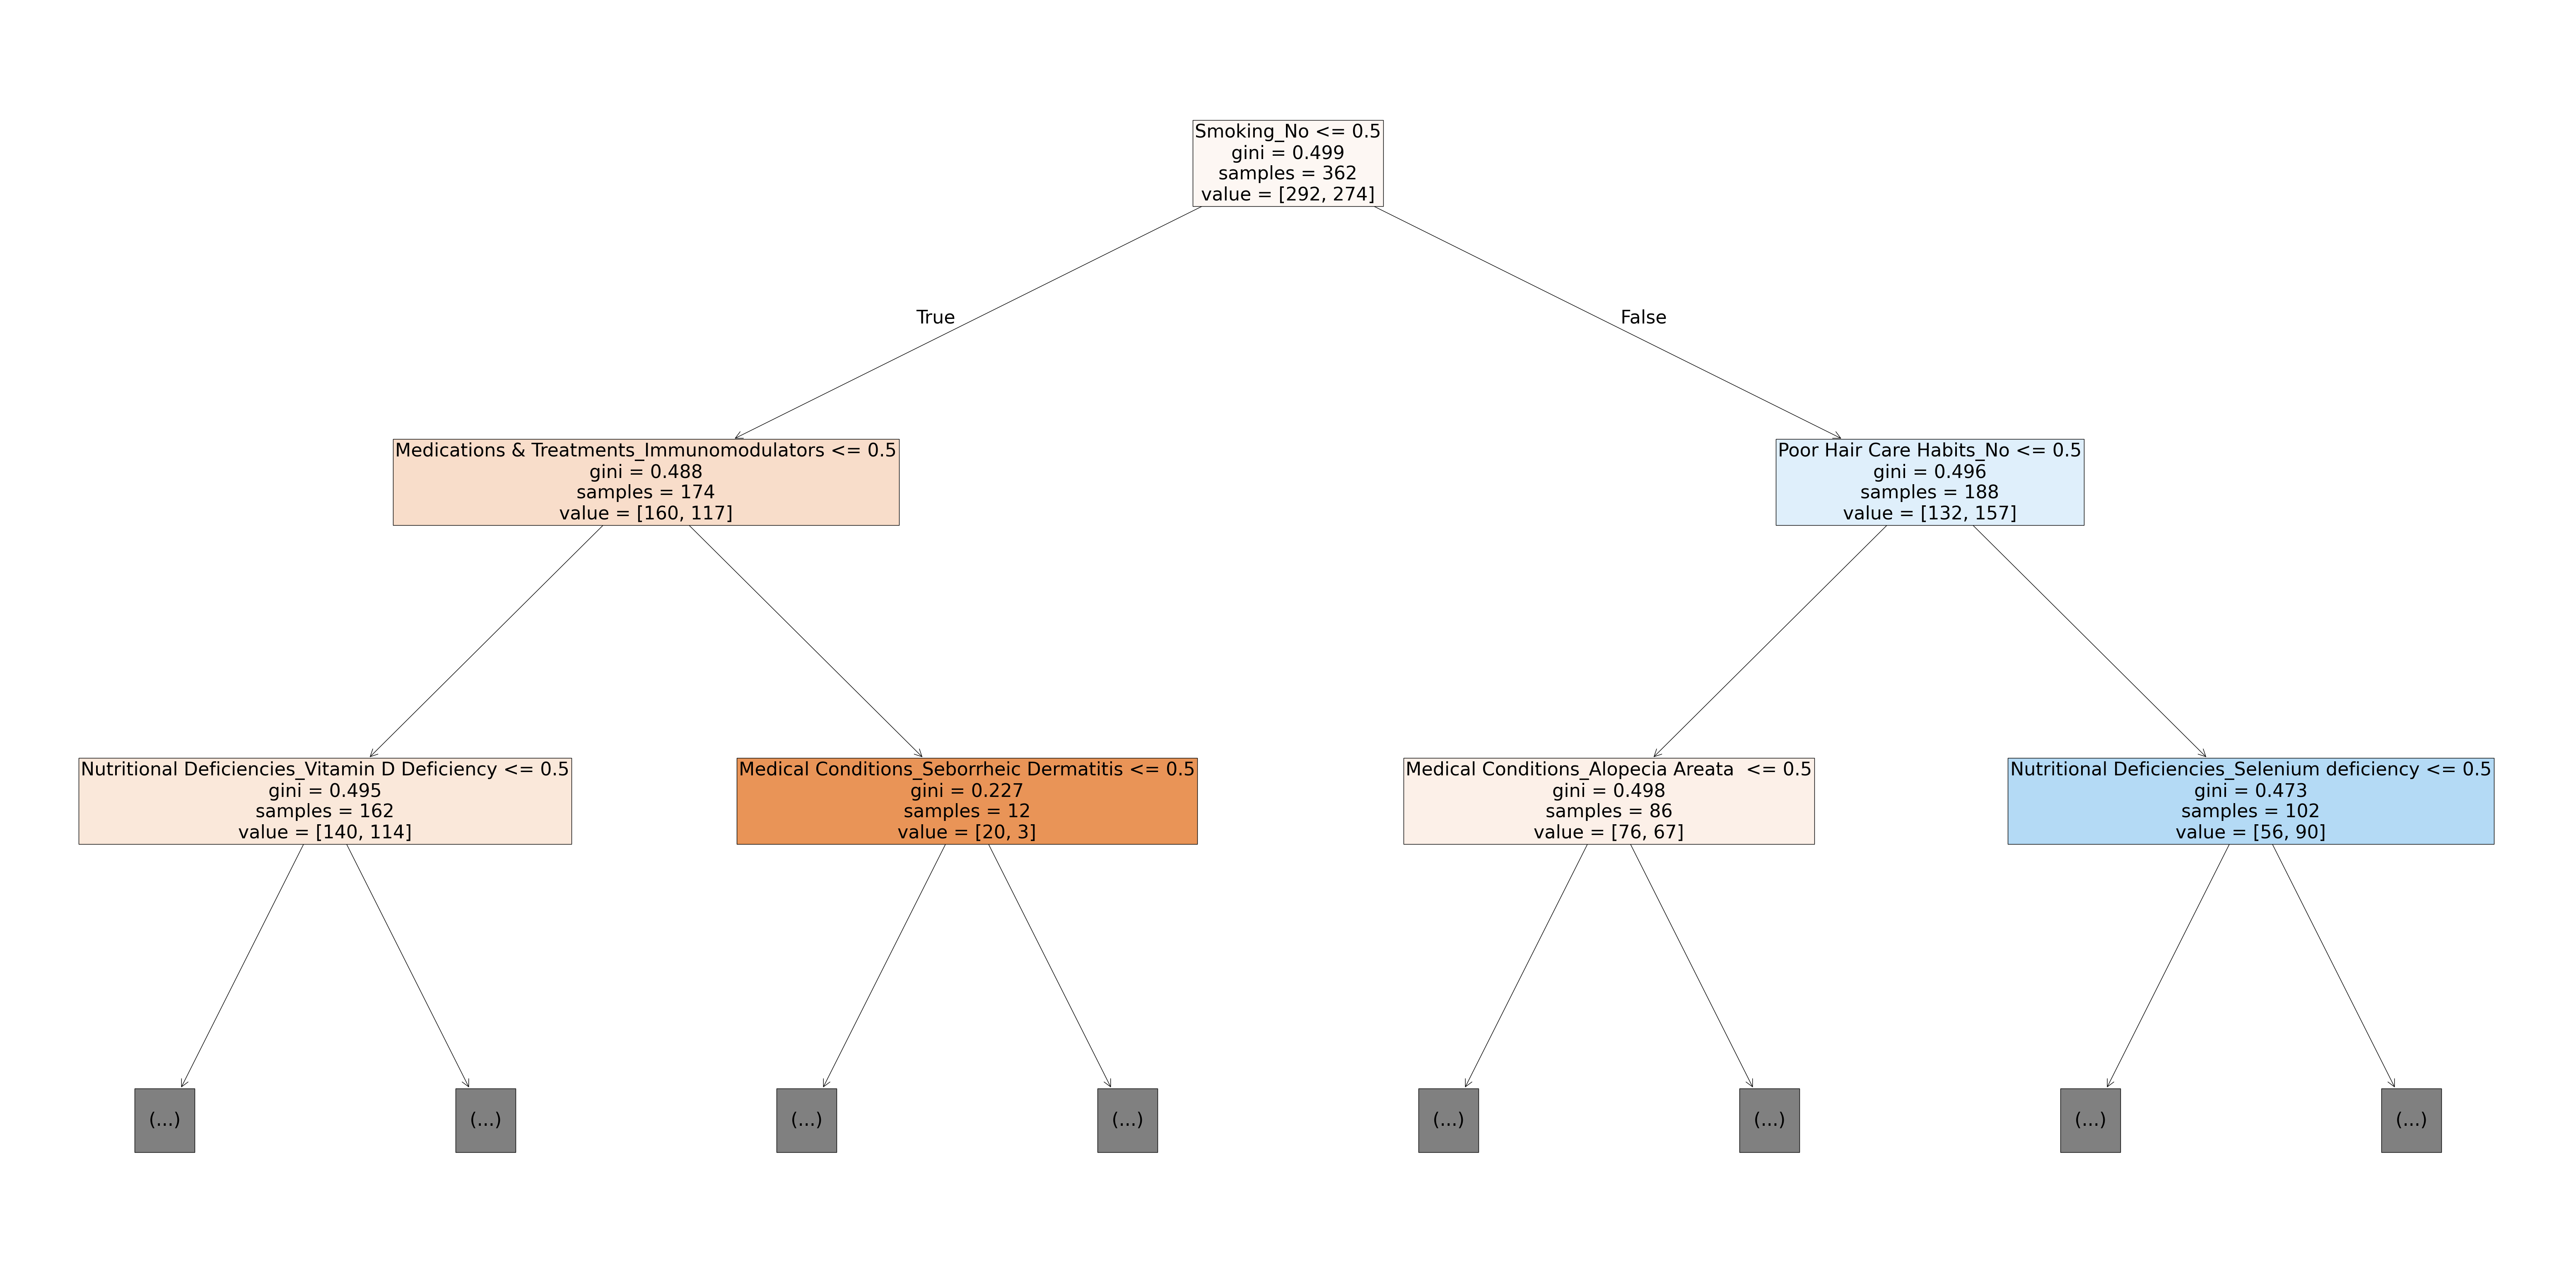

In [50]:
estimator = model_rf.estimators_[0]

plt.figure(figsize=(80, 40))
plot_tree(model_rf.estimators_[0], feature_names=X.columns, filled=True, max_depth=2, fontsize=32)
plt.show() 

## Step 3: Model Evaluation

Now moving on the check how well the model can predict whether an individual may face hair loss. 

In [51]:
y_pred = model_rf.predict(X_test) 

#model_rf.score(X_test, y_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.49      0.51       125
           1       0.50      0.55      0.53       118

    accuracy                           0.52       243
   macro avg       0.52      0.52      0.52       243
weighted avg       0.52      0.52      0.52       243



This shows that the model has a 51.85 predictive accuracy, which means it predicts the correct output about 50% of the time. This is not a great metric to have. <br> 
One reason for these results could be that the variables are not good predictors. The next line of code checks which variables were given the most importance in predicting. 

In [87]:
features = pd.DataFrame(model_rf.feature_importances_, index = X.columns, columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)

features.head()


,Feature Importance
Age,0.136818
Stress,0.049652
Medications & Treatments_Immunomodulators,0.030688
Hormonal Changes_No,0.027917
Smoking_Yes,0.026480


It seems that Age and Stress where the variables with greatest influence in determining Hair Loss. <br>

Below is a confusion matrix represeting the model's performance. 

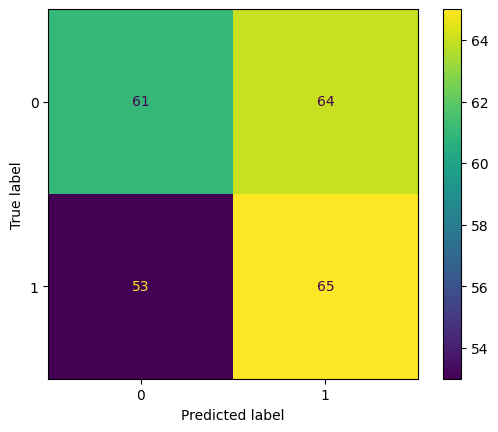

In [129]:
matrix = confusion_matrix(y_test,y_pred)

ConfusionMatrixDisplay(matrix).plot()

### Tuning Hyperparameters 

This is to see if the model's performace can be improved by changing the model's parameters. 

In [80]:
params = {
    'max_depth': [5, 10, 50, None], 
    'min_samples_leaf': [5, 10, 100, 200],
    'n_estimators': [10, 20, 30, 35]
}

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = 7, scoring='accuracy')
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 20}

In [113]:
model2 = RandomForestClassifier(random_state=42, max_depth=50, min_samples_leaf=5, n_estimators=20) 

model2.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, min_samples_leaf=5, n_estimators=20,
                       random_state=42)

In [114]:
y_pred = model2.predict(X_test) # max_depth=10, oob_score=True

model2.score(X_test, y_test)

0.522633744855967

## Final Observations 

The random forest model was able to predict with about 51.85% accuracy whether an individual was likely to face hair loss or not. <br> 

This can be indicative of the fact that the variables present in the data frame are not strong predictors of Hair Loss in individuals. 